### Galaxy-Flux correlation in bins of K

In [7]:
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import treecorr
import matplotlib.pyplot as plt


def read_catalog(path='../data/', 
                 name='2mrs_1175_done.dat', ncols=29, cz_min=1200):
  
  with open(path+name, 'r') as file:
    archivo = file.readlines()
    header  = [a.replace('#','').split() for a in archivo[:10]]
    lines   = archivo[10:]
  
  columns = header[-1]
  assert(len(columns) == ncols)
  print("Read %s\nColumns:" % name)
  print(columns)
  
  g = [[] for _ in range(ncols)]     
  for line in lines:
    values = line.split()
    g[0].append(            values[0]);   g[1].append(np.float32(values[1]));   g[2].append(np.float32(values[2]));
    g[3].append(np.float32( values[3]));  g[4].append(np.float32(values[4]));   g[5].append(np.float32(values[5]));
    g[6].append(np.float32( values[6]));  g[7].append(np.float32(values[7]));   g[8].append(np.float32(values[8]));
    g[9].append(np.float32( values[9]));  g[10].append(np.float32(values[10])); g[11].append(np.float32(values[11]));
    g[12].append(np.float32(values[12])); g[13].append(np.float32(values[13])); g[14].append(np.float32(values[14]));
    g[15].append(np.float32(values[15])); g[16].append(np.float32(values[16])); g[17].append(np.float32(values[17]));
    g[18].append(np.float32(values[18])); g[19].append(np.float32(values[19])); g[20].append(np.float32(values[20]));
    g[21].append(           values[21]) ; g[22].append(           values[22]);  g[23].append(values[23]); g[24].append(np.int32(values[24]));
    g[25].append(np.int32(  values[25])); g[26].append(           values[26]);  g[27].append(values[27]); g[28].append(         values[28])
  
  data = Table()
  for idx, col in enumerate(columns):
    data[col] = np.array(g[idx])

  data = data[data['v'] > cz_min]  
  data = data[data['DECdeg'] < 45.]
  
  # Create ks column for K-band absolute magnitude
  from astropy.constants import c
  cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
  comoving_dist = cosmo.comoving_distance((data['v']*u.km/u.s)/c) 
  data['z'] = (data['v']*u.km/u.s / c).to_value(u.one)
  mu = cosmo.distmod(data['z']).value                   # distance modulus in mag (uses D_L correctly)

  data['M_Ks'] = data['k_tc'] - mu  # - Kcorr - Aext

  data['M_Ks'] = -25 - 5 * np.log10(data['v']/100.) + data['k_tc']  

  data['_RAJ2000'] = data['RAdeg']  
  data['_DEJ2000'] = data['DECdeg']  
  data['cz'] = data['v']

  return data

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    # Generate random RA and Dec within specified declination limits
    rand_ra = np.random.uniform(0, 360, N_total*3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total*3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    # Apply Milky Way mask
    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points generated: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 200,
    "cross_patch_weight": 'geom'
}

"""
READ DATA
"""
# === Load galaxy catalogue ===
gxs = read_catalog()

# Validate gxs catalog
required_columns = ['_RAJ2000', '_DEJ2000', 'cz']
for col in required_columns:
    if col not in gxs.colnames:
        raise ValueError(f"Missing required column '{col}' in galaxy catalog.")

# === Load flux catalog ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=20)


Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']


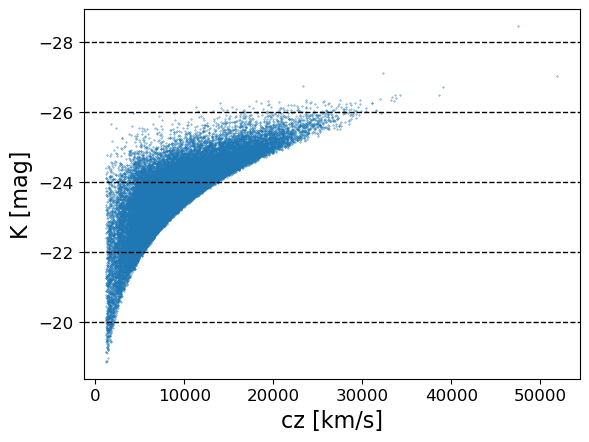

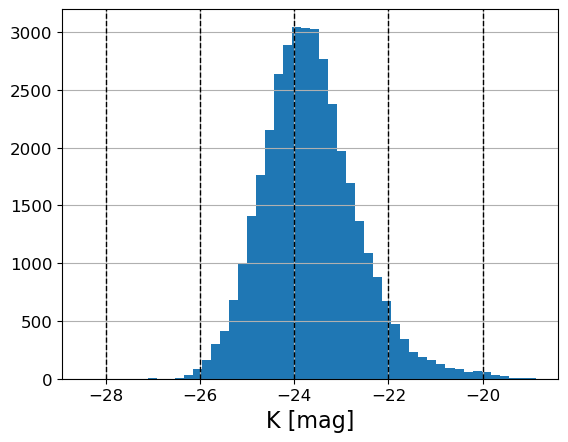

In [8]:
plt.scatter(gxs['cz'], gxs['M_Ks'], s=.1)
plt.xlabel('cz [km/s]')
plt.ylabel('K [mag]')
for K in [-20, -22, -24, -26, -28]:
    plt.axhline(K, color='k', ls='--', lw=1)
plt.axhline
plt.gca().invert_yaxis()
#plt.grid()
plt.show()

plt.hist(gxs['M_Ks'], bins=50, color='C0')
for K in [-20, -22, -24, -26, -28]:
    plt.axvline(K, color='k', ls='--', lw=1)
plt.xlabel('K [mag]')
plt.grid()
plt.show()

Processing slice: -22 -20
N. of galaxies in slice: 2038


RuntimeError: Cross correlation requires both catalogs use the same patches.

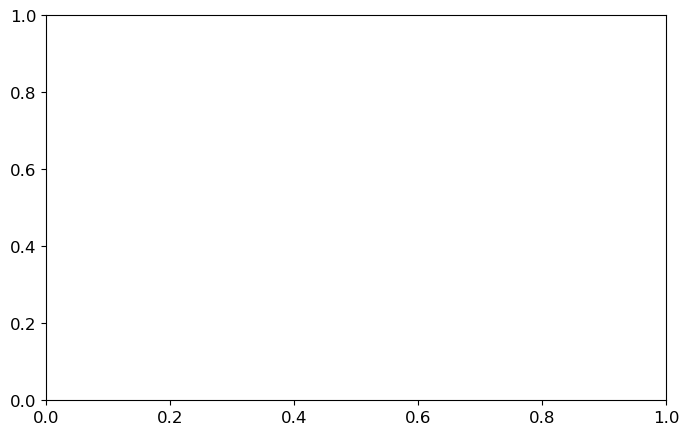

In [9]:

"""
CALCULATE CORRELATIONS FOR CZ SLICES
"""
k_slices = [(-20,-22), (-22,-24), (-24,-26), (-26,-28)]
colors = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

fig, ax = plt.subplots(figsize=(8, 5))

for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs[(gxs['M_Ks'] > k_min) & (gxs['M_Ks'] <= k_max)]

    print('N. of galaxies in slice:', len(gxs_slice))

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_slice)*10, dec_min=-90, dec_max=45)

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                  ra_units='deg', dec_units='deg', npatch=10)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)

    xi = xi / flux_val.mean()  # Normalize by mean flux value
    # Plot with color gradient
    # plt.errorbar(nk.meanr, xi/flux_val.mean(), yerr=varxi**.5, fmt='o-', color=colors[i],
    #              label=f'{cz_min} < cz <= {cz_max}')
    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors[i], label=f'{k_min} < K <= {k_max}')

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 18,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})

# Add colorbar using a dummy ScalarMappable
# norm = plt.Normalize(vmin=cz_slices[0][0], vmax=cz_slices[-1][1])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm.set_array([])  # dummy array
# cbar = fig.colorbar(sm, ax=ax)
# cbar.set_label('cz range')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

### Low K gxs have more correlation with flux, but there is a bias with cz 

Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']
-20
-23
-26


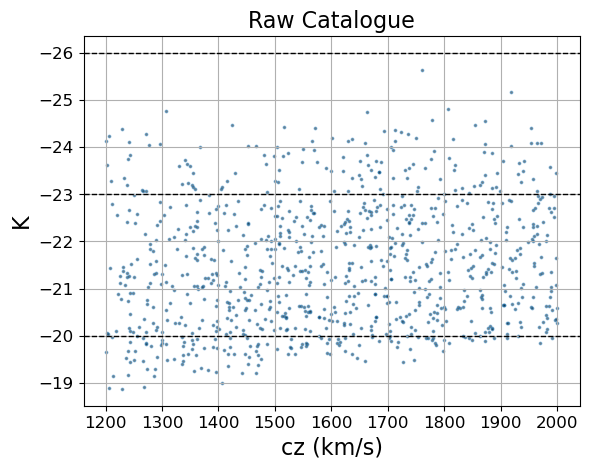

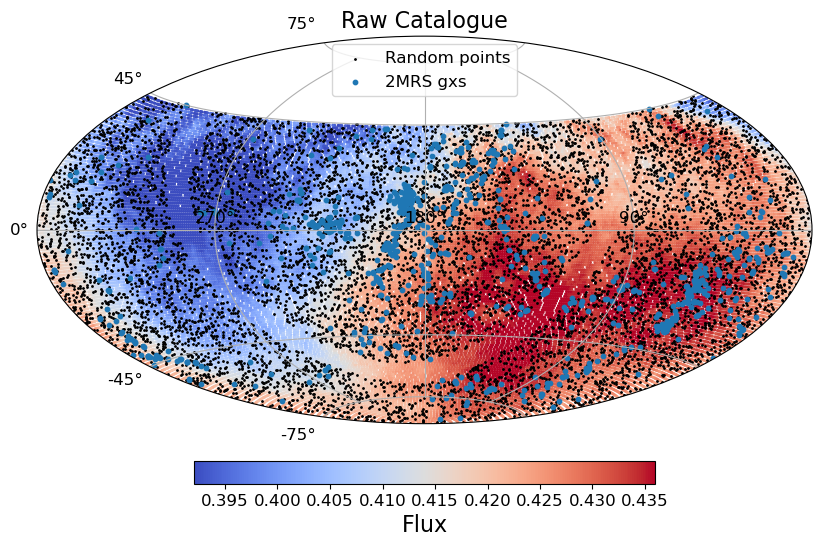

Processing slice: -21 -20
Processing slice: -26 -23


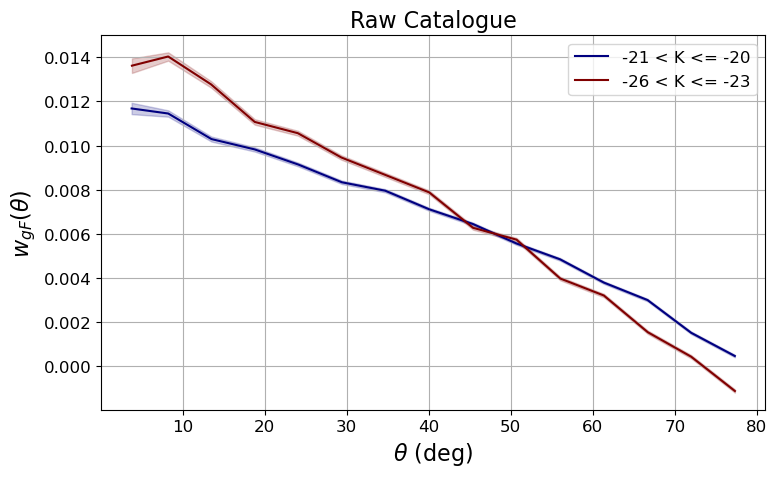

In [ ]:
"""
CALCULATE CORRELATIONS FOR K SLICES WITH CZ CUT
"""
# === Load Galaxies ===
gxs = read_catalog(cz_min=1200)
k_slices = [(-20, -21), (-23,-26)]
colors_kslices = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 2000)]  # Apply cz cut to galaxy catalog

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg')#, npatch=10)

# Generate random catalog for the current slice
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*10, dec_min=-90, dec_max=45)

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    #"var_method": 'bootstrap',
    #"num_bootstrap": 500,
    "cross_patch_weight": 'geom'
}

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})
#################
#################
# Plot K vs CZ
#################
#################
plt.scatter(gxs_K['cz'], gxs_K['M_Ks'], s=3, color='C0', alpha=0.5, label='K vs cz', facecolor='k')
for K in [item[0] for item in k_slices] + [k_slices[-1][1]]:
    print(K)
    plt.axhline(K, color='k', ls='--', lw=1)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('cz (km/s)')
plt.ylabel('K')
plt.title('Raw Catalogue')
plt.show()

#################
#################
# Plot SkyMap
#################
#################
from matplotlib import colors

# === Plot ===
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Set ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])

# === Flux Scatter plot (with horizontal colorbar below) ===
norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
sc = ax.scatter(np.deg2rad(-flux_ra+180.), np.deg2rad(flux_dec), c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')

# Horizontal colorbar for Flux
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")

ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec), s=1, color='k', label='Random points')
ax.scatter(np.deg2rad(-gxs_K['_RAJ2000']+180.), np.deg2rad(gxs_K['_DEJ2000']), s=10, color='C0', label='2MRS gxs')
plt.legend()
plt.title('Raw Catalogue')
plt.show()

######################
######################
# Plot Correlations
######################
######################
fig, ax = plt.subplots(figsize=(8, 5))
for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs_K[(gxs_K['M_Ks'] > k_min) & (gxs_K['M_Ks'] <= k_max)]

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                  ra_units='deg', dec_units='deg')#, npatch=10)
    rand_cat = treecorr.Catalog(ra=rand_ra[:len(gxs_slice)*10], dec=rand_dec[:len(gxs_slice)*10], 
                                ra_units='deg', dec_units='deg')#, patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    xi, varxi = nk.calculateXi(rk=rk)
    xi /= flux_val.mean()  # Normalize by mean flux value
    varxi = varxi / (flux_val.mean()**2)

    plt.fill_between(nk.meanr, xi - (varxi**0.5), xi + (varxi**0.5), 
                     color=colors_kslices[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors_kslices[i], label=f'{k_min} < K <= {k_max}')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.title('Raw Catalogue')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

#### Just want to check controlled catalogue

-21
-23
-26


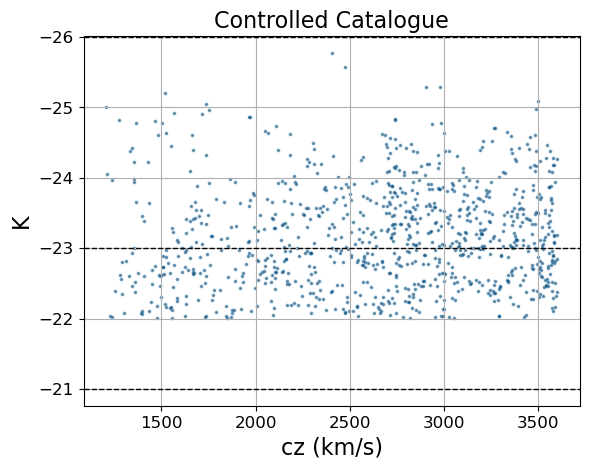

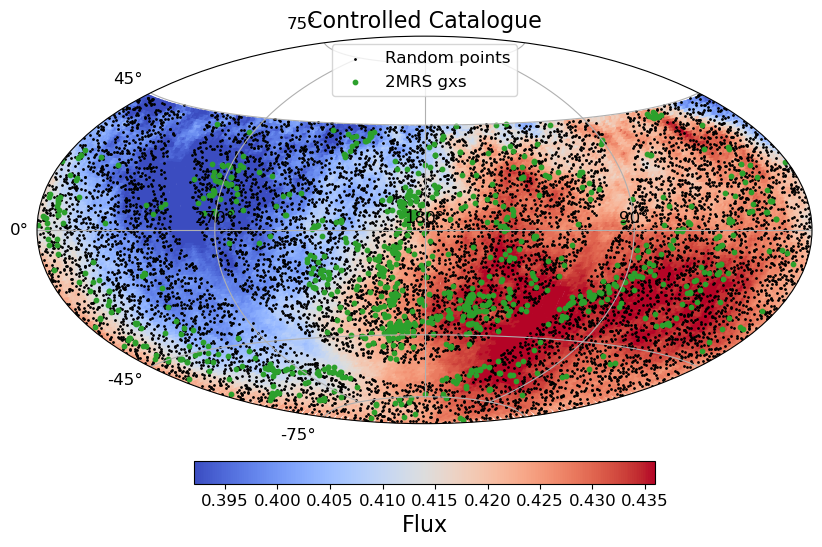

Processing slice: -23 -21
[0.00884321 0.00890273 0.00865358 0.00830967 0.00795132 0.0076631
 0.00729849 0.00695439 0.00646434 0.00575807 0.0048297  0.00388143
 0.00297578 0.00205952 0.00129453] [8.65789818e-06 7.79408759e-06 7.24706740e-06 6.79867917e-06
 6.54403262e-06 6.50306968e-06 6.57273596e-06 6.50767889e-06
 6.31781045e-06 6.22389535e-06 6.25098371e-06 6.20253837e-06
 6.21454816e-06 6.32488209e-06 6.42657855e-06]
Processing slice: -26 -23
[ 1.10537914e-02  1.09800366e-02  1.07142712e-02  1.02662213e-02
  9.83624526e-03  9.23008608e-03  8.62272191e-03  7.97785883e-03
  7.22109826e-03  6.17009572e-03  5.12690969e-03  3.78753308e-03
  2.39722938e-03  1.08263687e-03 -1.09313017e-05] [1.06871819e-05 9.82919190e-06 9.14260631e-06 8.61100566e-06
 8.13372179e-06 7.73671043e-06 7.48225899e-06 7.29196325e-06
 7.05405757e-06 6.81818281e-06 6.43050770e-06 6.01815786e-06
 5.67438763e-06 5.44174330e-06 5.34624414e-06]


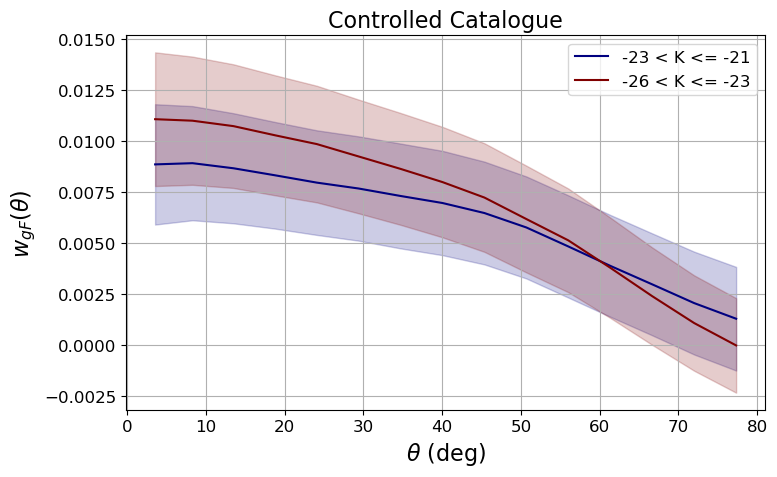

In [ ]:
"""
CALCULATE CORRELATIONS FOR K SLICES WITH CZ CUT
"""
# === Load Galaxies ===
from astropy.io import ascii
gxs_file = '../data/2MRSxWISE_VLS_d1d5_sinAGNWISEniBPT_control_SF_passive_cz_Kabs_ang5_cz1000.txt'
gxs = ascii.read(gxs_file)
gxs['M_Ks'] = gxs['K_abs']

k_slices = [(-21,-23), (-23,-26)]
colors_kslices = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 3600)]  # Apply cz cut to galaxy catalog

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)

# Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
flux_dec = flux_cat[:, 0]
flux_ra = flux_cat[:, 1]
flux_val = flux_cat[:, 2]

# Create flux catalog for treecorr
fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                        ra_units='deg', dec_units='deg', npatch=30)

# Generate random catalog
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*10, dec_min=-90, dec_max=45)

config = {
    "min_sep": 0.,
    "max_sep": 80.,
    "nbins": 15,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'bootstrap',
    "num_bootstrap": 500,
    "cross_patch_weight": 'geom'
}

# Set font sizes
plt.rcParams.update({
    'font.size': 14,          # default text size
    'axes.labelsize': 16,     # x/y labels
    'axes.titlesize': 16,     # plot titles
    'xtick.labelsize': 12,    # x tick labels
    'ytick.labelsize': 12,    # y tick labels
    'legend.fontsize': 12     # legend text
})
#################
#################
# Plot K vs CZ
#################
#################
plt.scatter(gxs_K['cz'], gxs_K['M_Ks'], s=3, color='C0', alpha=0.5, label='K vs cz', facecolor='k')
for K in [item[0] for item in k_slices] + [k_slices[-1][1]]:
    print(K)
    plt.axhline(K, color='k', ls='--', lw=1)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('cz (km/s)')
plt.ylabel('K')
plt.title('Controlled Catalogue')
plt.show()

#################
#################
# Plot SkyMap
#################
#################
from matplotlib import colors

# === Plot ===
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Set ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])

yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])

# === Flux Scatter plot (with horizontal colorbar below) ===
norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
sc = ax.scatter(np.deg2rad(-flux_ra+180.), np.deg2rad(flux_dec), c=flux_val, s=5, cmap='coolwarm', norm=norm_flux)

# Horizontal colorbar for Flux
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")

ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec), s=1, color='k', label='Random points')
ax.scatter(np.deg2rad(-gxs_K['_RAJ2000']+180.), np.deg2rad(gxs_K['_DEJ2000']), s=10, color='C2', label='2MRS gxs')
plt.legend()
plt.title('Controlled Catalogue')
plt.show()

######################
######################
# Plot Correlations
######################
######################
fig, ax = plt.subplots(figsize=(8, 5))
for i, (k_max, k_min) in enumerate(k_slices):

    print('Processing slice:', k_min, k_max)

    # Filter galaxies for the current cz slice
    gxs_slice = gxs_K[(gxs_K['M_Ks'] > k_min) & (gxs_K['M_Ks'] <= k_max)]

    # Create treecorr catalogs for the current slice
    gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                  ra_units='deg', dec_units='deg', npatch=30)
    rand_cat = treecorr.Catalog(ra=rand_ra[:len(gxs_slice)*10], dec=rand_dec[:len(gxs_slice)*10], 
                                ra_units='deg', dec_units='deg', patch_centers=gcat_slice.patch_centers)

    # Calculate correlations
    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)
    nk.process(gcat_slice, fcat)
    rk.process(rand_cat, fcat)
    #xi, varxi = nk.calculateXi(rk=rk)
    #xi = xi / flux_val.mean()  # Normalize by mean flux value

    # Pruebita
    xi = (nk.xi - flux_val.mean())  / flux_val.mean()  
    varxi = nk.varxi
    print(xi, varxi)
    #plt.errorbar(nk.meanr, xi, yerr=(varxi**.5), fmt='o-', color=colors_kslices[i])
    plt.fill_between(nk.meanr, xi - varxi**0.5, xi + varxi**0.5, 
                     color=colors_kslices[i], alpha=0.2)  # Add error band
    plt.plot(nk.meanr, xi, color=colors_kslices[i], label=f'{k_min} < K <= {k_max}')

# Finalize plot
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel(r'$w_{gF}(\theta)$')
ax.grid()
ax.legend(loc='upper right')
plt.title('Controlled Catalogue')
plt.tight_layout()
#plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
plt.show()

### Plot con el raw catalog
### Bootstrap artesanales (sólo bootstrapear galaxias)

Read 2mrs_1175_done.dat
Columns:
['ID', 'RAdeg', 'DECdeg', 'l', 'b', 'k_c', 'h_c', 'j_c', 'k_tc', 'h_tc', 'j_tc', 'e_k', 'e_h', 'e_j', 'e_kt', 'e_ht', 'e_jt', 'e_bv', 'r_iso', 'r_ext', 'b/a', 'flgs', 'type', 'ts', 'v', 'e_v', 'c', 'vsrc', 'CAT_ID']
-20
-23
-26


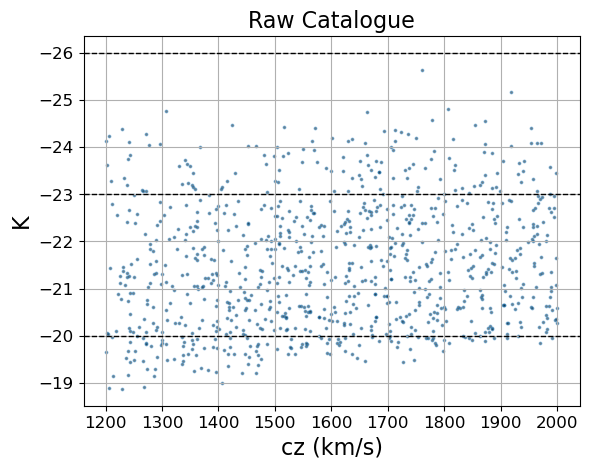

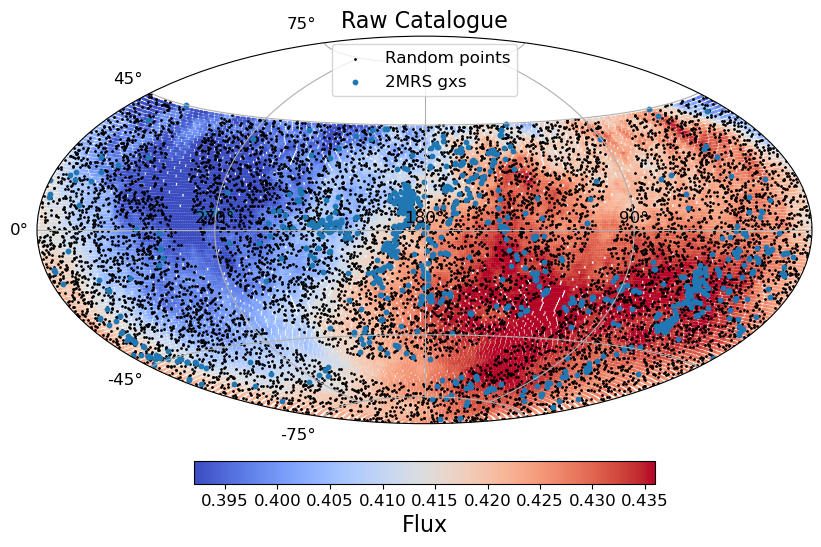

Processing slice: -21 -20
Processing slice: -26 -23


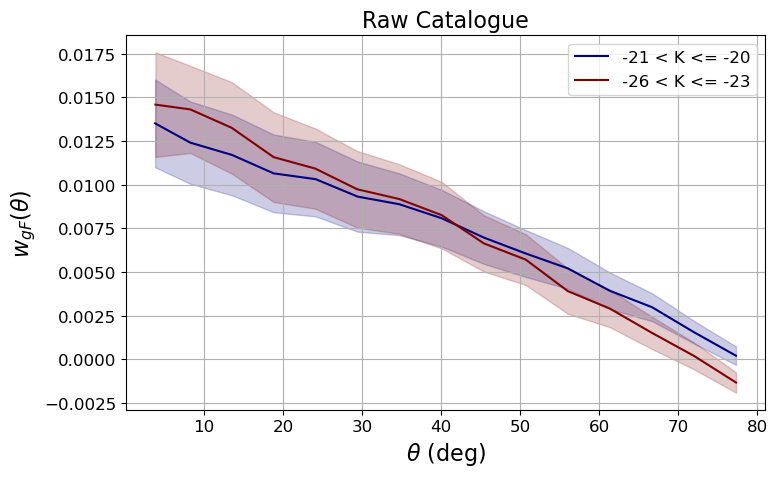

In [15]:
    """
    CALCULATE CORRELATIONS FOR K SLICES WITH CZ CUT
    """
    # === Load Galaxies ===
    gxs = read_catalog(cz_min=1200)
    k_slices = [(-20, -21), (-23,-26)]
    colors_kslices = plt.cm.jet(np.linspace(0, 1, len(k_slices)))  # Color gradient

    gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 2000)]  # Apply cz cut to galaxy catalog

    # === Load Flux map ===
    file_path = "../data/Auger/flux_a8_lb.dat"
    flux_cat = np.loadtxt(file_path)

    # Columns: Dec, RA, Flux, Flux_unc, Gal_l, Gal_b
    flux_dec = flux_cat[:, 0]
    flux_ra = flux_cat[:, 1]
    flux_val = flux_cat[:, 2]

    # Create flux catalog for treecorr
    fcat = treecorr.Catalog(ra=flux_ra, dec=flux_dec, k=flux_val,
                            ra_units='deg', dec_units='deg')#, npatch=10)

    # Generate random catalog for the current slice
    rand_ra, rand_dec = generate_RanCat(len(gxs_K)*10, dec_min=-90, dec_max=45)

    config = {
        "min_sep": 0.,
        "max_sep": 80.,
        "nbins": 15,
        "sep_units": 'degree',
        "bin_type": 'Linear',
        "brute": False,
        "metric": 'Arc',
        #"var_method": 'bootstrap',
        #"num_bootstrap": 500,
        "cross_patch_weight": 'geom'
    }

    # Set font sizes
    plt.rcParams.update({
        'font.size': 14,          # default text size
        'axes.labelsize': 16,     # x/y labels
        'axes.titlesize': 16,     # plot titles
        'xtick.labelsize': 12,    # x tick labels
        'ytick.labelsize': 12,    # y tick labels
        'legend.fontsize': 12     # legend text
    })
    #################
    #################
    # Plot K vs CZ
    #################
    #################
    plt.scatter(gxs_K['cz'], gxs_K['M_Ks'], s=3, color='C0', alpha=0.5, label='K vs cz', facecolor='k')
    for K in [item[0] for item in k_slices] + [k_slices[-1][1]]:
        print(K)
        plt.axhline(K, color='k', ls='--', lw=1)
    plt.gca().invert_yaxis()
    plt.grid()
    plt.xlabel('cz (km/s)')
    plt.ylabel('K')
    plt.title('Raw Catalogue')
    plt.show()

    #################
    #################
    # Plot SkyMap
    #################
    #################
    from matplotlib import colors

    # === Plot ===
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111, projection='hammer')
    ax.grid(True)

    # Set ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f"{d}°" for d in xticks_deg])

    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f"{d}°" for d in yticks_deg])

    # === Flux Scatter plot (with horizontal colorbar below) ===
    norm_flux = colors.Normalize(vmin=np.percentile(flux_val, 5), vmax=np.percentile(flux_val, 95))
    sc = ax.scatter(np.deg2rad(-flux_ra+180.), np.deg2rad(flux_dec), c=flux_val, s=5, cmap='coolwarm', norm=norm_flux, edgecolor='none')

    # Horizontal colorbar for Flux
    cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
    cbar_flux.set_label("Flux")

    ax.scatter(np.deg2rad(-rand_ra+180.), np.deg2rad(rand_dec), s=1, color='k', label='Random points')
    ax.scatter(np.deg2rad(-gxs_K['_RAJ2000']+180.), np.deg2rad(gxs_K['_DEJ2000']), s=10, color='C0', label='2MRS gxs')
    plt.legend()
    plt.title('Raw Catalogue')
    plt.show()

    ######################
    ######################
    # Plot Correlations
    ######################
    ######################
    fig, ax = plt.subplots(figsize=(8, 5))
    for i, (k_max, k_min) in enumerate(k_slices):

        print('Processing slice:', k_min, k_max)

        # Filter galaxies for the current k slice
        gxs_slice = gxs_K[(gxs_K['M_Ks'] > k_min) & (gxs_K['M_Ks'] <= k_max)]

        # Create treecorr catalogs for the current slice
        gcat_slice = treecorr.Catalog(ra=gxs_slice['_RAJ2000'], dec=gxs_slice['_DEJ2000'],
                                    ra_units='deg', dec_units='deg')#, npatch=10)
        rand_cat = treecorr.Catalog(ra=rand_ra[:len(gxs_slice)*10], dec=rand_dec[:len(gxs_slice)*10], 
                                    ra_units='deg', dec_units='deg')#, patch_centers=gcat_slice.patch_centers)

        # Calculate correlations
        nk = treecorr.NKCorrelation(config)
        rk = treecorr.NKCorrelation(config)
        nk.process(gcat_slice, fcat)
        rk.process(rand_cat, fcat)
        xi, _ = nk.calculateXi(rk=rk)
        #xi = nk.xi - flux_val.mean()
        xi /= flux_val.mean()  # Normalize by mean flux value

        # --- bootstrap variance function (uses same estimator and same rk) ---
        def get_bootstrap_variance(gxs_slice, rand_cat, fcat, config, num_bootstrap=500, use_patches=False):
            nbins = config['nbins']
            xi_bs = np.zeros((num_bootstrap, nbins))

            if use_patches:
                # Example using healpix patch bootstrap (recommended if you care about spatial systematics)
                import healpy as hp
                nside = 16   # tune this (8,16,32) depending on patch size you want
                npix = hp.nside2npix(nside)
                # get pixel indices for galaxies
                theta = np.deg2rad(90. - gxs_slice['_DEJ2000'])
                phi = np.deg2rad(gxs_slice['_RAJ2000'])
                gpix = hp.ang2pix(nside, theta, phi)
                patch_indices = [np.where(gpix == p)[0] for p in range(npix)]

                for i in range(num_bootstrap):
                    sel_patches = np.random.randint(0, npix, size=npix)
                    idxs = np.concatenate([patch_indices[p] for p in sel_patches if patch_indices[p].size>0])
                    if idxs.size == 0:
                        continue
                    gbs = gxs_slice[idxs]

                    gcat_bs = treecorr.Catalog(ra=gbs['_RAJ2000'], dec=gbs['_DEJ2000'],
                                            ra_units='deg', dec_units='deg')
                    nk_bs = treecorr.NKCorrelation(config)
                    rk_bs = treecorr.NKCorrelation(config)
                    nk_bs.process(gcat_bs, fcat)
                    rk_bs.process(rand_cat, fcat)          # keep the same randoms (they describe geometry)
                    xi_bs[i], _ = nk_bs.calculateXi(rk=rk_bs)
            else:
                # Simple iid bootstrap (fast, ok if spatial systematics are negligible)
                for i in range(num_bootstrap):
                    sel = np.random.choice(len(gxs_slice), size=len(gxs_slice), replace=True)
                    gbs = gxs_slice[sel]
                    gcat_bs = treecorr.Catalog(ra=gbs['_RAJ2000'], dec=gbs['_DEJ2000'],
                                            ra_units='deg', dec_units='deg')
                    nk_bs = treecorr.NKCorrelation(config)
                    rk_bs = treecorr.NKCorrelation(config)
                    nk_bs.process(gcat_bs, fcat)
                    rk_bs.process(rand_cat, fcat)
                    xi_bs[i], _ = nk_bs.calculateXi(rk=rk_bs)

            # variance of xi (in same units as xi); ddof=1 for unbiased estimate
            return np.var(xi_bs, axis=0, ddof=1)
        
        var_bs = get_bootstrap_variance(gxs_slice, rand_cat, fcat, config, num_bootstrap=500, use_patches=True)
        varxi = var_bs / (flux_val.mean()**2)

        plt.fill_between(nk.meanr, xi - (varxi**0.5), xi + (varxi**0.5), 
                        color=colors_kslices[i], alpha=0.2)  # Add error band
        plt.plot(nk.meanr, xi, color=colors_kslices[i], label=f'{k_min} < K <= {k_max}')

    # Finalize plot
    ax.set_xlabel(r'$\theta$ (deg)')
    ax.set_ylabel(r'$w_{gF}(\theta)$')
    ax.grid()
    ax.legend(loc='upper right')
    plt.title('Raw Catalogue')
    plt.tight_layout()
    #plt.savefig('gal_flux_correlation.png', dpi=300)  # Save the figure
    plt.show()